# Promedio RMS de $Ro = \left|\frac{\zeta}{f}\right|$ en función del tiempo

In [1]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [18]:
image_outfolder = "/home/antonio/GoogleDrive/Tesis/spectral_analysis_data/output_images"

In [2]:
import imageio
import numpy as np
from scipy import signal
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from xmitgcm import open_mdsdataset
from datetime import date,datetime,timedelta

In [3]:
def fig2img(fig):
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(),dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

In [4]:
def savefig(f,*args,**kvargs):
    fig = f(*args,**kvargs)
    image = fig2img(fig)
    plt.close(fig=fig)
    return image

In [5]:
idx_t_JFM_days = [i for i in range(377) if i>=110 and i<201]
idx_t_JAS_days = [i for i in range(377) if i>=292]
idx_t_JFM_hours = [(24*i)+hr for i in range(377) if i>=110 and i<201 for hr in range(24)]
idx_t_JAS_hours = [(24*i)+hr for i in range(377) if i>=292  for hr in range(24)][:-18]
idx_t = {
	"days": {
		"JFM": idx_t_JFM_days,
		"JAS": idx_t_JAS_days,
		"JFMJAS": idx_t_JFM_days+idx_t_JAS_days
	},
	"hours": {
		"JFM": idx_t_JFM_hours,
		"JAS": idx_t_JAS_hours,
		"JFMJAS": idx_t_JFM_hours+idx_t_JAS_hours
	}
}

In [6]:
ids_Cal = [762, 787, 809, 831, 852, 868] # California -- 23 to 51 N
ids_Can = [709, 730, 750, 771] # Canarias -- 16 to 36 N
ids_Peru = [450, 572, 596] #616,636  Peru Chile -- 5 to 45 S
ids_Ben = [533, 578, 602] #459,556, Benguela -- 15 to 37 S ** Quitamos la **459** y ponemos la 602
ids_Kuro = [733, 751, 796]
ids_regions = {
    "California": list(reversed(ids_Cal)),
    "Canarias": list(reversed(ids_Can)),
    "Peru": list(reversed(ids_Peru)),
    "Benguela": list(reversed(ids_Ben)),
    "Kuroshio": list(reversed(ids_Kuro))
}

In [7]:
grid_ds = open_mdsdataset('/home/antonio/GoogleDrive/LLC2160/grid/', read_grid=True, iters=None, default_dtype=np.float32, geometry='llc')
grid_ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 2160, i_g: 2160, j: 2160, j_g: 2160, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    XG      

In [8]:
LON_ = grid_ds.XG.values
LAT_ = grid_ds.YG.values
DEPTH_ = grid_ds.Depth.values

In [9]:
uv_fname_fmt_days = "/home/antonio/Tesis/Datasets/{0}/days/{1}0_{2:05d}.txt"
uv_fname_fmt_hours = "/home/antonio/Tesis/Datasets_compressed/{0}/hours/{1}0_{2:05d}.npz"
def uv4idt(region_id,t_idx,t_res="days"):
	if t_res=="days":
		U_ = np.loadtxt(uv_fname_fmt_days.format(region_id,"U",t_idx))
		V_ = np.loadtxt(uv_fname_fmt_days.format(region_id,"V",t_idx))
	else:
		U_ = np.load(uv_fname_fmt_hours.format(region_id,"U",t_idx))["uv"]
		V_ = np.load(uv_fname_fmt_hours.format(region_id,"V",t_idx))["uv"]
	return U_,V_

In [10]:
def UV4id(id,season,t_res="days",t_firstaxis=False):
	time = idx_t[t_res][season]
	
	for idx,t in enumerate(time):
		U_,V_ = uv4idt(id,t,t_res)
		if idx==0:
			#print(id,t)
			shape_uv = U_.shape
			#print("UV shape",shape_uv)
			shape = (shape_uv[0],shape_uv[1],len(time))
			U = np.zeros(shape)
			V = np.zeros(shape)
		U[:,:,idx] = U_
		V[:,:,idx] = V_

	if t_firstaxis:
		U = np.moveaxis(U,-1,0)
		V = np.moveaxis(V,-1,0)

	return U,V

In [11]:
dxdy_fname_fmt = "/home/antonio/Tesis/Datasets/{}/days/{}.txt"
def dxdyf4id(region_id):
    dx_ = np.loadtxt(dxdy_fname_fmt.format(region_id,"dx"))
    dy_ = np.loadtxt(dxdy_fname_fmt.format(region_id,"dy"))
    f_ = np.loadtxt(dxdy_fname_fmt.format(region_id,"f"))
    
    return dx_,dy_,f_

def lonlat4id(region_id):
    lon = np.loadtxt(dxdy_fname_fmt.format(region_id,"lon"))
    lat = np.loadtxt(dxdy_fname_fmt.format(region_id,"lat"))
    return lon,lat

In [12]:
def rv_(u,v,dx,dy):
    return (np.gradient(v,axis=-1,edge_order=2)/dx) - (np.gradient(u,axis=-2,edge_order=2)/dy)

In [13]:
def getBathymetry(area_box):
    print("Bathymetry for box",area_box)
    min_lon,max_lon,min_lat,max_lat = area_box
    mask_lonlat_f = np.where((LON_>=min_lon) & (LON_<=max_lon) & (LAT_>=min_lat) & (LAT_<=max_lat))
    faces = set(mask_lonlat_f[0])
    print("faces",faces)
    LON_area = [None]*len(faces)
    LAT_area = [None]*len(faces)
    DEPTH_area = [None]*len(faces)
    for i,face in enumerate(faces):
        LON_f = LON_[face,:,:]
        LAT_f = LAT_[face,:,:]
        mask_lonlat = np.where((LON_f>=min_lon) & (LON_f<=max_lon) & (LAT_f>=min_lat) & (LAT_f<=max_lat))
        min_i,max_i = min(mask_lonlat[0]),max(mask_lonlat[0])
        min_j,max_j = min(mask_lonlat[1]),max(mask_lonlat[1])
        print(face,min_i,max_i,min_j,max_j)
        LON_area[i] = LON_f[min_i:max_i,min_j:max_j]
        LAT_area[i] = LAT_f[min_i:max_i,min_j:max_j]
        DEPTH_area[i] = DEPTH_[face,min_i:max_i,min_j:max_j]
    return LON_area,LAT_area,DEPTH_area

In [14]:
def plotBathymetry(area_box):
    LON,LAT,DEPTH = getBathymetry(area_box)
    print("depth len",len(DEPTH))
    for i in range(len(DEPTH)):
        LON_f = LON[i]
        LAT_f = LAT[i]
        DEPTH_f = DEPTH[i]
        print(LON_f.shape,LAT_f.shape,DEPTH_f.shape)
        #plt.pcolormesh(LON_f,LAT_f,DEPTH_f,cmap=plt.cm.Pastel1,norm=norm_bath)
        cs = plt.contour(LON_f,LAT_f,DEPTH_f,levels=[0,200,1000],cmap=plt.cm.Greys_r,extend="max",zorder=0)
        plt.clabel(cs, inline=True, fontsize='large',fmt="%d")

In [15]:
margin = 6
firstday = datetime(2012,1,1)

def plot_ro_region_t(current,t_idx,t_vec,t_res="days",norm=False,absolute=False):
	rv_range = 1 if norm else 0.8
	rv_type = "Normalized " if norm else ""
	o_fmt = "" if norm else " $[10^{-4} s^{-1}]$"
	dt_days = 1 if t_res=="days" else 24
	divnorm_ro = colors.DivergingNorm(vmin=-rv_range, vcenter=0, vmax=rv_range)
	
	#fig, ax = plt.subplots(1,2,figsize=(20,10))
	fig = plt.figure(figsize=(10,10))
	#ax = ax.flat[:]
	t_ = t_vec[t_idx]
	t__ = t_ - idx_t[t_res]["JFM"][0]
	t_delta = timedelta(hours=t__) if t_res=="hours" else timedelta(days=t__)
	t_label = (firstday + t_delta).date()
	#t_label = [t__-idx_t[t_res]["JFM"][0]+1 for t__ in t_vec]
	print(t_idx+1,"/",len(t_vec))
	lon_min,lat_min,lon_max,lat_max = (180,90,-180,-90)

	for r_id in ids_regions[current]:
		#Ro_vec = Ro_dict[r_id]
		print("U,V for {} ({})".format(r_id,t_res))
		U,V = uv4idt(r_id,t_,t_res)
		DX,DY,F = dxdyf4id(r_id)
		norm_rv = F if norm else 1e-4
		rv_sum = F if absolute else 0
		Ro = (rv_(U,V,DX,DY)+rv_sum)/norm_rv
		#Ro_vec[t_idx] = np.sqrt(np.mean(Ro**2))
		LON,LAT = lonlat4id(r_id)
		lon_min = min(lon_min,np.min(LON))
		lat_min = min(lat_min,np.min(LAT))
		lon_max = max(lon_max,np.max(LON))
		lat_max = max(lat_max,np.max(LAT))
		#plt.sca(ax[0])
		plt.pcolormesh(LON,LAT,Ro,norm=divnorm_ro,cmap=plt.cm.RdBu,zorder=10)
		#plt.sca(ax[1])
		#plt.plot(t_label,Ro_vec,label="{0:d} @ {1:0.1f},{2:0.1f}".format(r_id,np.mean(LON),np.mean(LAT)))
	#plt.sca(ax[0])
	plt.colorbar()
	box = (lon_min,lon_max+margin,lat_min,lat_max)
	plotBathymetry(box)
	plt.xlabel("Longitude",fontsize='large')
	plt.ylabel("Latitude",fontsize='large')
	plt.title(t_label,fontsize='x-large')
	#plt.sca(ax[1])
	#plt.xlim([t_label[0],t_label[-1]])
	#plt.xlabel("Year{}".format(t_res),fontsize='large')
	#plt.ylabel("RMS(Ro)",fontsize='large')
	#plt.title("RMS(Ro) by region - {}".format(current),fontsize='x-large')
	#plt.legend()
	plt.axis("equal")

	fig.suptitle("{}Relative Vorticity{}".format(rv_type,o_fmt),fontsize='xx-large')
	return fig#,ax

In [219]:
t_r = "days"
fps = 3 if t_r == "days" else 6
for current,ids in ids_regions.items():
	if current=="California":
		for season in ["JAS","JFM"]:
			times = idx_t[t_r][season]
			n_times = len(times)
			#o_d = {r_id:[None]*n_times for r_id in ids}
			print(current,season)
			fname_gif = '{}/rms_ro_all_{}_{}.gif'.format(image_outfolder,current,season)
			Path(fname_gif).mkdir(parents=True, exist_ok=True)
			imageio.mimsave(fname_gif, 
							(savefig(plot_ro_region_t,current,idx_t,times,t_r,norm=False,absolute=False) for idx_t in range(n_times)), 
							 fps=fps,loop=10)
			print("Saved!",fname_gif)
		gc.collect()

California JAS
1 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
2 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
3 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 

24 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
25 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
26 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth l

47 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
48 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
49 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth l

70 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
71 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
72 / 85
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth l

8 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
9 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
10 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len

31 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
32 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
33 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth l

54 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
55 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
56 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth l

77 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
78 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth len 2
(288, 864) (288, 864) (288, 864)
(287, 864) (287, 864) (287, 864)
79 / 91
U,V for 868 (days)
U,V for 852 (days)
U,V for 831 (days)
U,V for 809 (days)
U,V for 787 (days)
U,V for 762 (days)
Bathymetry for box (-140.00000000000003, -115.99999999999997, 24.176759957937914, 50.258499145507805)
faces {10, 7}
10 0 288 1007 1871
7 1872 2159 1007 1871
depth l

## Graficando RMS(Ro)

In [16]:
def getRoRms(r_id,season,t_res="days",norm=False,absolute=False):
	U,V = UV4id(r_id,season,t_res=t_res,t_firstaxis=True)
	DX,DY,F = dxdyf4id(r_id)
	norm_rv = F if norm else 1e-4
	sum_rv = F if absolute else 0
	Ro = (rv_(U,V,DX,DY)+sum_rv)/norm_rv
	#return np.sqrt(np.mean(Ro**2,axis=(1,2)))
	return np.std(Ro,axis=(1,2))

In [17]:
prop_cycle = plt.rcParams['axes.prop_cycle']

def roRmsByCurrent(current,season,t_res="days",norm=True,absolute=False):
	times = np.array(idx_t[t_res][season])
	n_times = len(times)
	n_ids = len(ids_regions[current])
	allRoRms = [getRoRms(r_id,season,t_res,norm,absolute) for r_id in ids_regions[current]]
	colors = prop_cycle.by_key()['color']
	var = "Ro" if norm else "RV"
	o_fmt = "" if norm else "\n$[10^{-4} s^{-1}]$"
	
	if t_res=="days":
		f_ticks_lab = [2,7,15,21,30,40]
		day_dt = 1
	else:
		f_ticks_lab = [h/24 for h in [6,12,24,7*24,15*24,30*24]]
		day_dt = 24
		
	t_label = [(t__-idx_t[t_res]["JFM"][0]+1)/day_dt for t__ in times]
	f = np.fft.rfftfreq(n_times,1) # T=1 {t_days}: intervalo de muestreo
		
	f_ticks = [1/(24*D) for D in f_ticks_lab]
	fig = plt.figure(figsize=(12,8),constrained_layout=True)
	gs = fig.add_gridspec(n_ids,2)
	
	axT = []
	axF = []
	maxY_t = 0
	minY_t = 1
	maxY_f = 0
	for i,r_id,ro_rms in zip(range(n_ids),ids_regions[current],allRoRms):
		_,LAT = lonlat4id(r_id)
		lat = np.median(LAT)
		lbl = "{0} @ {1:0.1f}".format(r_id,lat)
		color = colors[i]
		#print("color",color)
		# Time domain
		ax0 = fig.add_subplot(gs[i,0])
		axT.append(ax0)
		plt.sca(ax0)
		maxY_t = max(maxY_t,np.max(ro_rms))
		minY_t = min(minY_t,np.min(ro_rms))
		plt.plot(t_label,ro_rms,label=lbl,color=color)
		plt.ylabel("Std({}){}".format(var,o_fmt),size="x-large")
		# Frequency domain
		ax1 = fig.add_subplot(gs[i,1])
		axF.append(ax1)
		plt.sca(ax1)
		ro_rms_det = signal.detrend(ro_rms,type='linear')
		rorms_f = np.abs(np.fft.rfft(ro_rms_det))
		maxY_f = max(maxY_f,np.max(rorms_f))
		plt.loglog(f,rorms_f,label=r_id,color=color)
		plt.xticks(ticks=f_ticks,labels=f_ticks_lab,size="large")
		print(r_id,minY_t,maxY_t,maxY_f)
		if i==n_ids-1:
			ax0.set_xlabel("Yeardays",size="x-large")
			ax1.set_xlabel("Period in days",size="x-large")
		if i==0:
			ax0.set_title("Time domain\n"+lbl)
			ax1.set_title("FFT \n"+lbl)
		else:
			ax0.set_title(lbl)
			ax1.set_title(lbl)
	plt.suptitle("{} / {}".format(current,season),size="xx-large")
	for axt,axf in zip(axT,axF):
		axt.set_ylim([minY_t,maxY_t])
		axf.set_ylim([1e-1,maxY_f])
	plt.show()	#print("Box",box)

868 0.1086662166762807 0.14842034699013815 3.702886651254086
852 0.1086662166762807 0.1676498577450613 6.323137243483559
831 0.1086662166762807 0.1716218648484484 6.323137243483559
809 0.1086662166762807 0.1990001064631586 8.40862656845722
787 0.1086662166762807 0.24397570200028298 13.659166428019137
762 0.1086662166762807 0.291467228038804 27.496091974062708


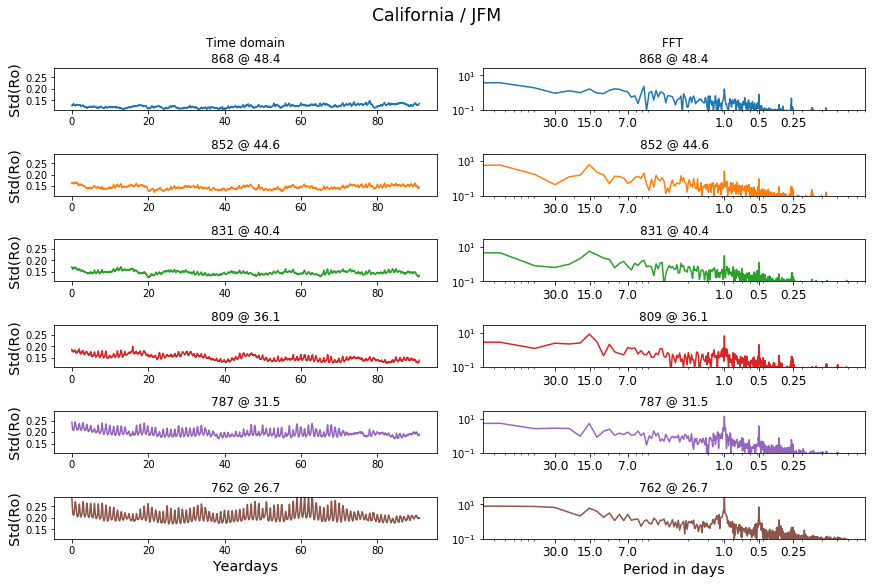

868 0.1642307497296726 0.23621452712917185 16.398416453087915
852 0.1642307497296726 0.2768429318917822 16.398416453087915
831 0.1642307497296726 0.2768429318917822 16.398416453087915
809 0.1642307497296726 0.2768429318917822 16.398416453087915
787 0.1642307497296726 0.2768429318917822 16.398416453087915
762 0.1642307497296726 0.2768429318917822 16.398416453087915


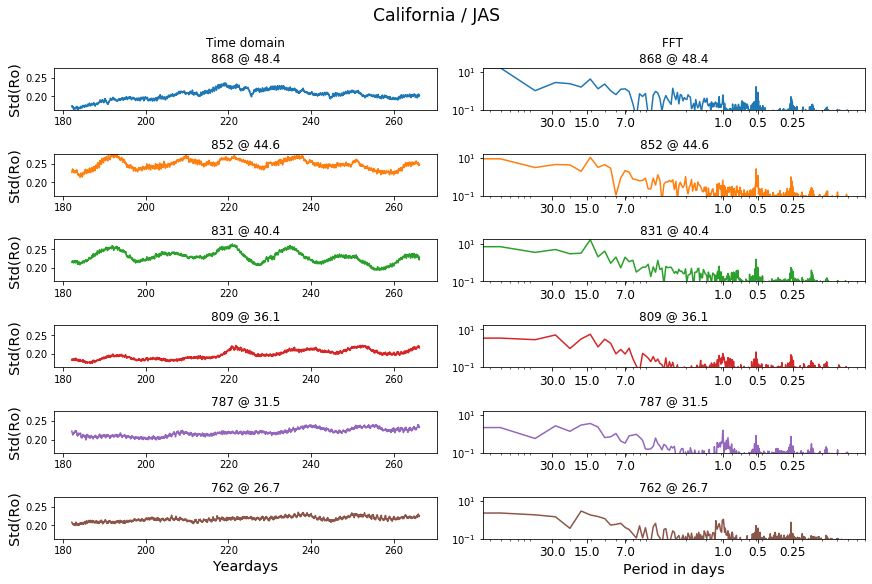

771 0.20513183316033845 0.4922023233803565 46.57190197293572
750 0.20513183316033845 0.4922023233803565 50.13014871997303
730 0.20513183316033845 0.5349733382763835 52.883302138659225
709 0.20513183316033845 0.5349733382763835 52.883302138659225


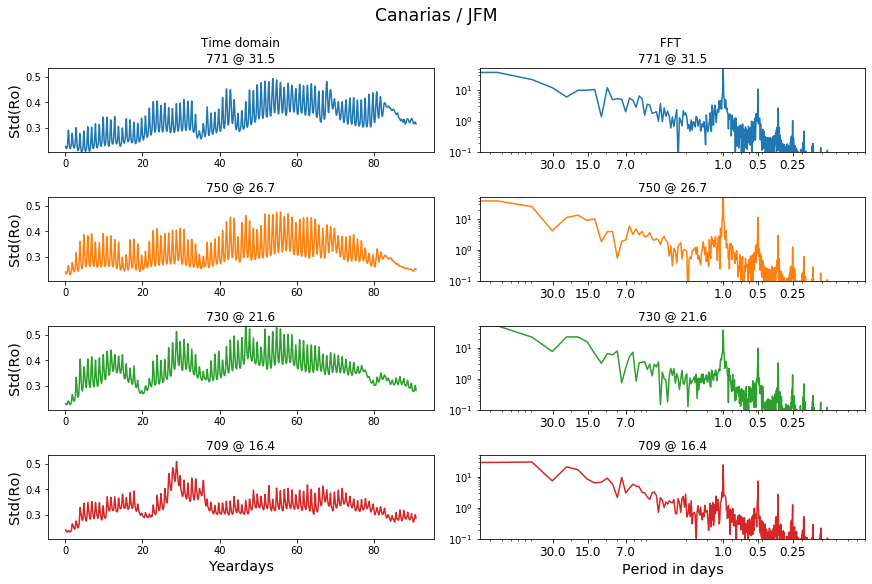

771 0.13778376408775508 0.1763635713387954 4.004437060274079
750 0.12069101638469065 0.1763635713387954 5.684811384951455
730 0.12069101638469065 0.17845256456725447 5.684811384951455
709 0.12069101638469065 0.25694856067873634 6.905481230123225


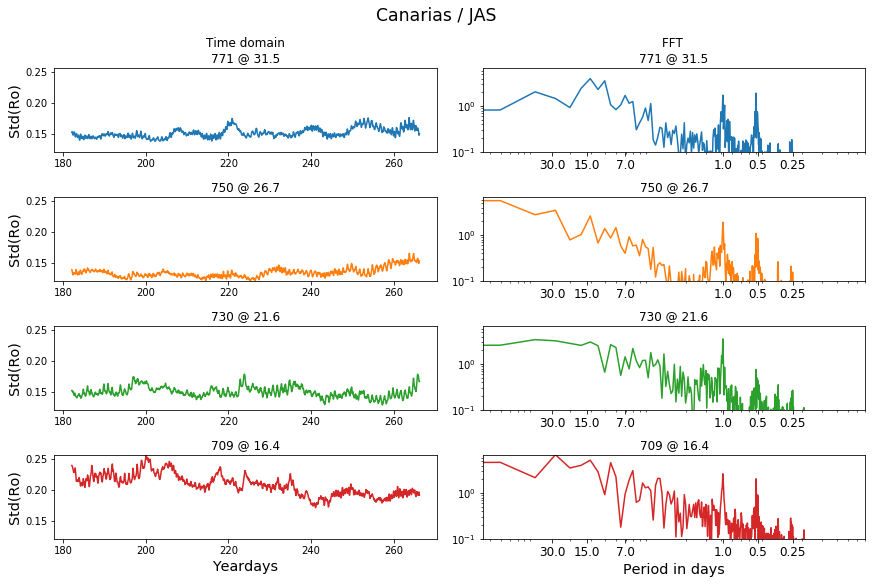

596 0.3350279122747701 0.4444533123415174 14.344362896292271
572 0.2500834945111545 0.4444533123415174 14.344362896292271
450 0.18018009024338189 0.4444533123415174 14.344362896292271


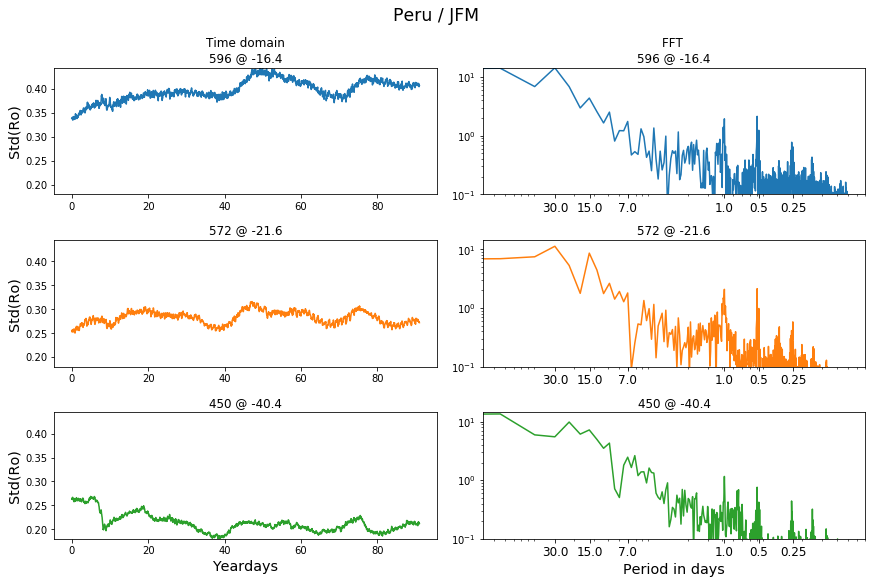

596 0.2506436105014458 0.3669190693914784 16.408228996978004
572 0.16070593069219322 0.3669190693914784 17.0147172973245
450 0.1282953762048484 0.3669190693914784 17.0147172973245


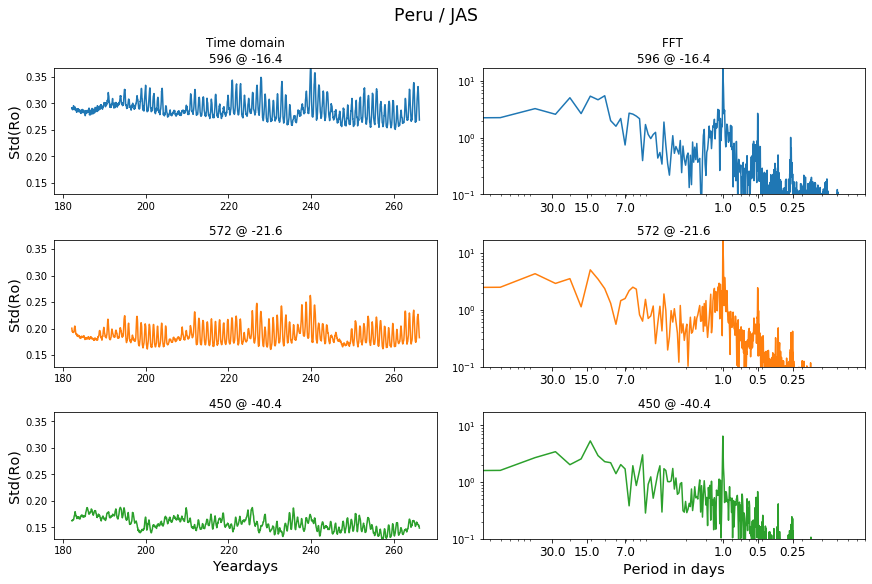

602 0.15958904776133795 0.2442073677904266 12.128589977717919
578 0.13464689220377493 0.2442073677904266 12.128589977717919
533 0.10918149885170768 0.2442073677904266 12.128589977717919


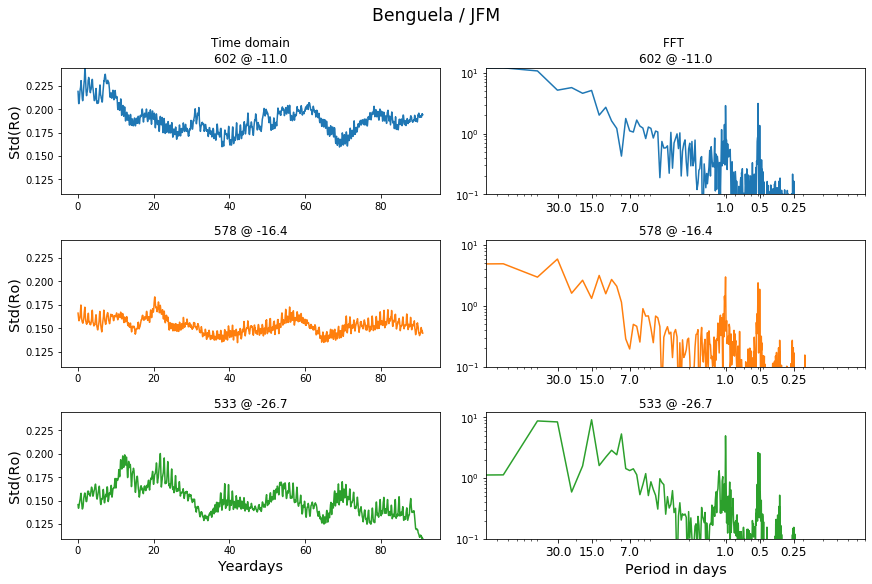

602 0.18558732916345785 0.3446879236827434 17.098153449098508
578 0.16492465424514752 0.3446879236827434 18.591788379544415
533 0.16492465424514752 0.3446879236827434 30.37443761824566


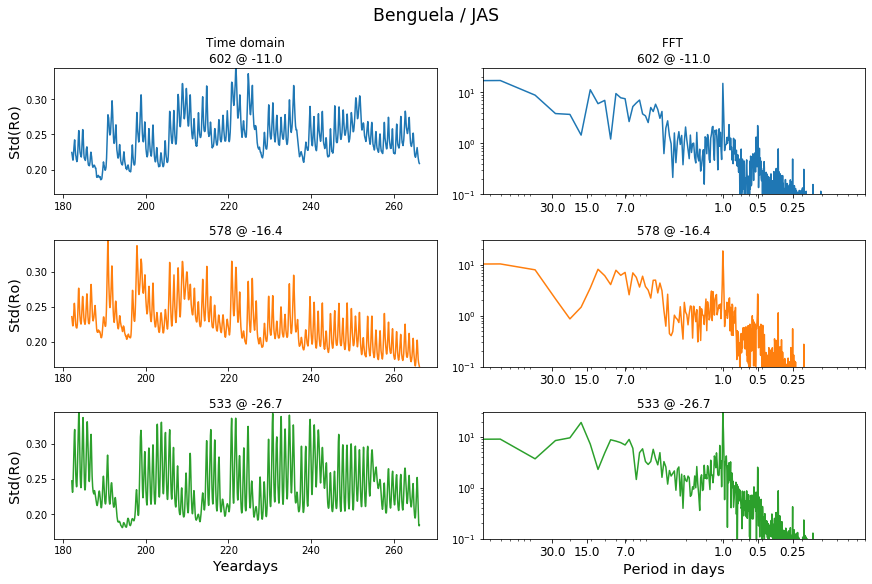

796 0.17870787074082672 0.3303164391930254 18.06054129919979
751 0.17870787074082672 0.39617406438856245 22.532637166996505
733 0.17870787074082672 0.5145809716152535 22.532637166996505


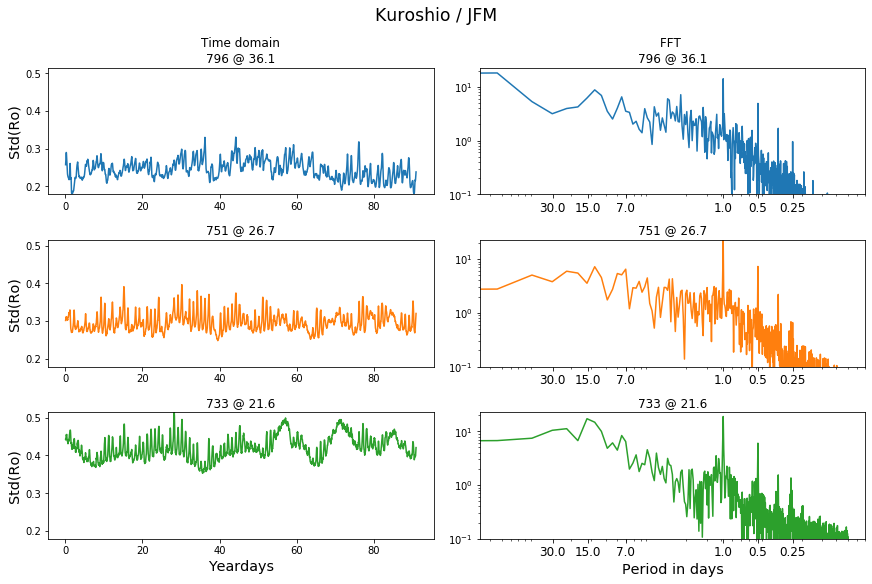

796 0.18945118726035162 0.24179362343273308 8.034773498413134
751 0.18945118726035162 0.5039207415082511 14.971790004785447
733 0.18945118726035162 0.6331318871397075 30.595691808742412


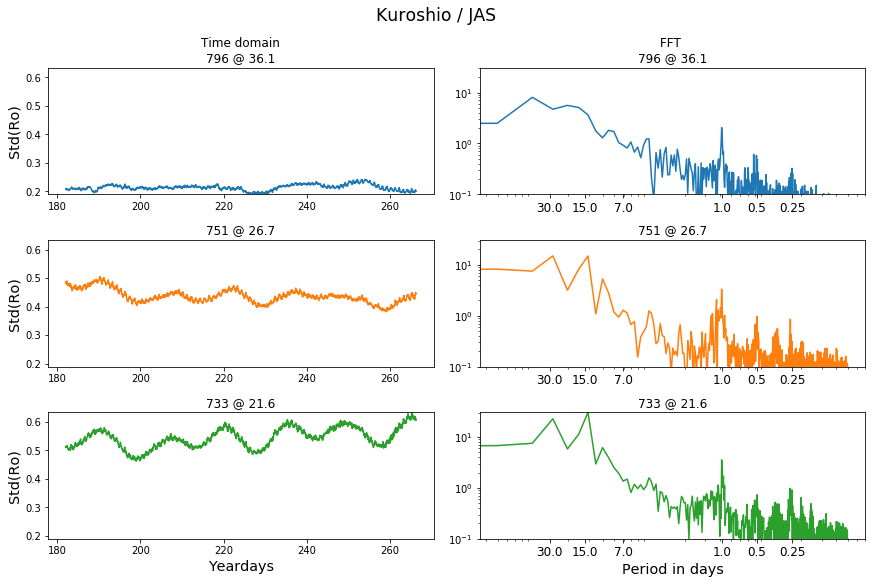

In [237]:
for current,season in product(ids_regions.keys(),["JFM","JAS"]):
	print(current,season)
	roRmsByCurrent(current,season,"hours")

### * Extra: Creando animación de RV para una región cualquiera

In [238]:
def plot_rv(rv,lon,lat):
	std = np.std(rv)
	divnorm_rv = colors.DivergingNorm(vmin=-1, vcenter=0, vmax=1)
	fig = plt.figure(figsize=(10,10))
	plt.pcolor(lon,lat,rv,norm=divnorm_rv,cmap=plt.cm.RdBu)
	plt.title("std(RV)={0:0.3f}".format(std),size="xx-large")
	return fig

def anim_rv(r_id,season):
	LON,LAT = lonlat4id(r_id)
	U,V = UV4id(r_id,season,t_res="days",t_firstaxis=True)
	DX,DY,F = dxdyf4id(r_id)
	nt,_,_ = U.shape
	rv_norm = rv_(U,V,DX,DY)/F
	#
	fname_gif = '{}/rv_{}_{}.gif'.format(image_outfolder,r_id,season)
	Path(fname_gif).mkdir(parents=True, exist_ok=True)
	imageio.mimsave(fname_gif, 
					(savefig(plot_rv,rv_norm[i,:,:],LON,LAT) for i in range(nt)), 
					 fps=3,loop=10)
	print("Saved!",fname_gif)

In [239]:
anim_rv(730,'JFM')

Saved! rv_730_JFM.gif
